# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

## Background
Photonic crystals (PhC) are micro/nano artificial atoms composed of periodically perturbed refractive indices dielectric material, which can manipulate the propagation of electromagnetic (EM) waves in a similar manner to how actual crystals manipulate electron waves. The periodic symmetry and Maxwell equations guarantee that the eigenmodes of EM waves can be held in PhC are represented by photonic band structures. One popular method to analyze the band structures of photonic crystals is to apply the Hamiltonian formalism, however, little research has been conducted on inferring the coupling strengths for Hamiltonian matrix from
experiment data in PhC. This will be the main purpose of our project.

## Generative Model: The Hamiltonian Matrix
The Hamiltonian matrix consists of frequencies of uncoupled slab modes on chosen momentum basis and the coupling intensity parameters between them. The former contribute to diagonal elements in the matrix, while the latter contribute to off diagonal terms. At a single momentum configuration $(k_x,k_y)$, the Hamiltonian matrix can be constructed and diagonolized to obtain the eigen frequencies of Bloch wave in photonic crystal. Due to the C4 symmetry of our square lattice, the allowed basis sizes are 5, 9, 13,...

Right now, this package allows you to infer the coupling parameters in a 5 basis model: 5 slab modes at $k$ point and its four nearest neighbor points in reciprocal space.

<img src="reference_img\basis-doodle.png" alt="Image" width="1000px" height="750px"/>

If $U_{10},U_{11}$ and $U_{20}$ represent couplings between Bloch waves with some momentum difference as shown in figure above, $\epsilon_i (i = 0,1,2,3,4)$ is the uncoupled energy of each slab mode, then the corresponding Hamiltonian matrix is:
$$ H =  \begin{pmatrix} \epsilon_0 & U_{10}& U_{10}& U_{10}& U_{10} \\ U_{10}& \epsilon_1 & U_{11}& U_{20}& U_{11} \\ U_{10}& U_{11}& \epsilon_2 & U_{11}& U_{20} \\ U_{10}& U_{20}&U_{11}& \epsilon_3 & U_{11}\\ U_{10}& U_{11}&U_{20}& U_{11}  & \epsilon_4  \end{pmatrix}$$

The matrix is inherently diagonalizable and has the eigenvalues $\{ e_0,e_1,e_2,e_3,e_4\}$. 

For a $k$ point located on $\Gamma M$ symmetric axis and near $\Gamma$ point, which corresponds to the actual data we chose to infer, we can further simplify the above Hamiltonian matrix. Firstly, due to the symmetry of $\Gamma M$ axis, degerated to two values, energies of slab modes are degenerate $\epsilon_1 = \epsilon_4 = \epsilon_0 + d\epsilon$, and $\epsilon_2 = \epsilon_3 = \epsilon_0 - d\epsilon$. Secondly, energy of slab mode near $\Gamma$ point where where $|k| < 0.1 |\Gamma M|$ is negligible compared to its four neighbors so we can safely ignore $\epsilon_0$ and $U_{10}$. Therefore, we get the reduced Hamiltonian matrix 
$$ H_{reduced} =  \begin{pmatrix} \epsilon_0+d\epsilon & U_{11}& U_{20}& U_{11} \\ U_{11}& \epsilon_0-d\epsilon & U_{11}& U_{20} \\ U_{20}&U_{11}& \epsilon_0-d\epsilon & U_{11}\\ U_{11}&U_{20}& U_{11}  & \epsilon_0+d\epsilon  \end{pmatrix}$$

And the eigenvalues $\{e_1,e_2,e_3,e_4\}$ represent 4 energy bands of the photonic crystal.  It is
important to note that $\epsilon_0$ and $d\epsilon$ depend on where the slab mode resides in $k$ space, while $U_{11}$ and $U_{20}$ only depend on the distance between nearest neighbor $k$ points. Thus, $U_{11}$ and $U_{20}$ are independent of $k$ value.

### Multiple Lorentzian Peak Model of the energy spectrum

In real measurement, 4 energy bands of the photonic crystals appear as four peaks in the single k frequency-intensity spectrum. Therefore, our statistical model for the energy spectrum is a multiple Lorentzian peak model where the peaks are centered at $\{C_1,C_2,C_3,C_4\}$.  The background $A_0$, amplitudes of four peaks $A_1, A_2, A_3, A_4$ and the peak quality factors $Q_1, Q_2, Q_3, Q_4$ are the nuisance parameters that we will marginalize over.

$$ \mu_i = A_0 + \sum_{j=1}^4 \frac{A \cdot W_j^2} {(W_j^2 + (x_i-C_j)^2)} $$

where $W_i$ is the half width at half maximum (HWHM) of Lorentz peak, $Q_i = C_i/W_i$.

We will discuss the priors for each type of parameter below.

For the coupling parameters $U_{11}$ and $U_{20}$, we have prior knowledge of their means values based on the electromagnetic field overlap of different slab modes and their variances based on previous research result. Moreover, there are no physical boundaries for these coupling parameters. Thus, we use the normal distribution as priors for $U_{11}$ and $U_{20}$. 

For the peak background, heights and quality factors, they are all required to be positive. We can estimate the mean value of peak heights as the typical brightness of bands on CCD pictures that are not saturated. The mean value of peak quality factors can be extracted from numerical simulation of the same system. Thus, we set exponential distribution for priors of peak heights (including background intensity) and quality factors.

Regarding the frequencies of initial slab modes, $\epsilon_0$ is bounded by the range of frequencies used in the measurement, while $d\epsilon$ is bounded by zero and half of frequency range to ensure the physical restriction. Therefore, we use uniform priors for $\epsilon_0$ and $d\epsilon$.

Lastly, we assign a normal likelihood for each data point in the spectrum. The likelihood mean is $\mu_i$, while the likelihood standard deviation $\sigma_i$ is treated as additional inferred parameter. $\sigma_i$ cannot be estimated directly during the measurement because the typical noises from CCD or laser fluctuation are negligible compared to the systematic uncertainty from four spectra measured for each k-point. Note that due to C4 symmetry, the spectra obtained from a k-point and its other three symmetric counterparts are considered as four spectra of the same k-point. This systematic uncertainty $\sigma_i$ can be written as $\sigma_i = s \cdot \sqrt{y_i}$, where $s$ is a nuisance scaling parameter. This scaling relationship is often used to estimate the uncertainty in the measured intensity: the photon counts' uncertainty is proportional to the square root of the counts themselves. We know typical value of $s$ and that $s$ is positive, so we can assign an exponential prior distribution to $s$.

In summary, the statistical model
\begin{aligned}
y_i & \sim \text{Normal} (\mu_i,\sigma_i) \\
\mu_i & = A_0 + \sum_{j=1}^4 \frac{A \cdot W_j^2} {(W_j^2 + (x_i-C_j)^2)}\\
C_j &= C_j(U_{11},U_{20},\epsilon_0, d\epsilon) \text{ via Hamiltonian matrix diagonalization}\\
W_j &= C_j/Q_j\\
U_{11}  & \sim \text{Normal} (U_{\text{11 mean}},U_{\text{11 std}}) \\
U_{20}  & \sim \text{Normal} (U_{\text{20 mean}},U_{\text{20 std}})\\
\epsilon_0   & \sim \text{Uniform}  (\epsilon_{\text{0 min}},\epsilon_{\text{0 max}})\\
d\epsilon   & \sim \text{Uniform}  (d\epsilon_{\text{min}},d\epsilon_{\text{max}})\\
A_0 & \sim \text{Exponential}  (A_{\text{0 mean}})  \\
A_j & \sim \text{Exponential}  (A_{j \text{mean}}) \\
Q_j & \sim \text{Exponential}  (Q_{j\text{mean}})\\
\sigma_i &= s \cdot  \sqrt{y_i} \\
s &\sim \text{Exponential} (s_{\text{mean}})
\end{aligned}

## Using the photonic-hamiltonian package

### Load the data file

Before using the package, please make sure that the data is converted into .nc format

Our io_data.py script provides the function which exports the data in .nc format into an xarray with data labels 'normf', 'y1', 'y2', 'y3', 'y4', which indicates four repeating measurement results

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
import seaborn as sns

from photonic_hamiltonian.inference import io_data
#load an example data file, data courtersy: Fan Du
#example data is taken at |k| = 0.06*|GM| of PhC chip 1
real_data = io_data.load_data('photonic_hamiltonian\data\expdata_singleKspectrum_060.nc')

We can plot this data to visualize how the four peaks look like in a real measurement

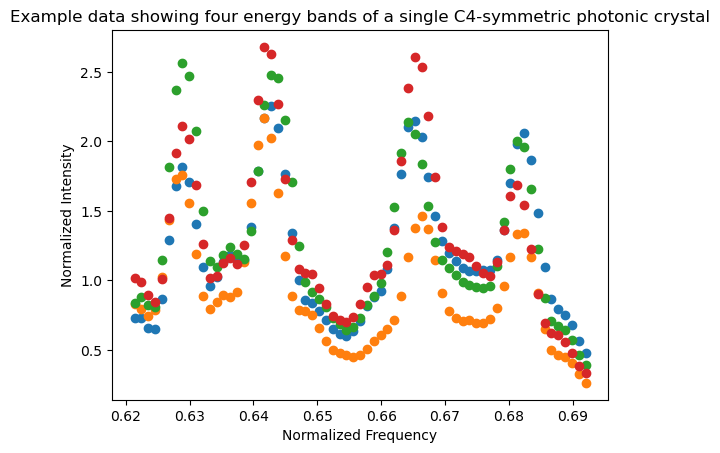

In [2]:
freq = real_data['normf'].to_numpy()
intensity = np.array([real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']])
plt.plot(freq, intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')
plt.show()

### Inference fit using pymc

In the package, the Model.py script has two functions: Hamiltonian_model and prediction_model.

$\textbf{Hamiltonian_model(data, prior_bounds)}$ function:
* It is used to define, diagonalize the Hamiltonian matrix, and build a multi Lorentzian peak model from the matrix's eigenvalues. You can use this pymc model for sampling, plotting the posterior, finding the maximum a posteriori (MAP) point, or estimating the parameters from the mean of posterior distribution.
* Its input parameters are data extracted and formatted by io.py, and a dictionary which maps parameters' names ('u11', 'u20', 'e0', 'de', 'A0', 'A1', 'A2', 'A3' , 'A4', 'Q1', 'Q2', 'Q3', 'Q4', 'sigma_y') to their corresponding prior types and coefficients.

$\textbf{prediction_model(theta, freq)}$ function:
 * It calculates the fitted intensity for a given set of fitting parameters
 * Its input parameters are the normalized frequency and a list of fitting parameters in the order [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]

In [3]:
from photonic_hamiltonian.inference import Model

#### Inference on simulated data

To test if running our model gives a reasonable result for parameter estimation, we first generate a simulated data with given values for all the parameters

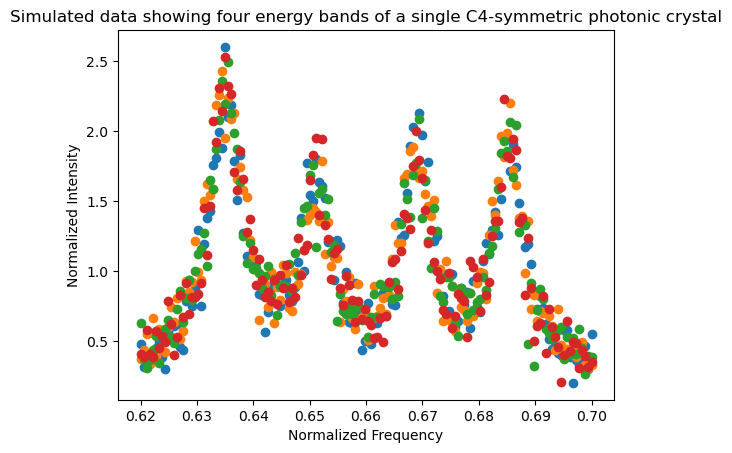

In [4]:
# Create simulated data
N = 150
simu_normf = np.linspace(0.62,0.70,N)    # create normalized frequency, "x" variable 

#set all hamiltonian parameters as some constants
u11 = 0.008
u20 = 5e-5
e0 = 0.66
de = 0.015
A0 = 0.3
[A1, A2, A3, A4] = [1.9, 1.2, 1.5, 1.6]
[Q1, Q2, Q3, Q4] = [180, 200, 210, 220]
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]
#create normalized intensity
line = Model.prediction_model(theta, simu_normf)

#create noise ratio
sigma_noise = 0.15

#create data array
simu_data = xr.Dataset(data_vars = {'y1': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N) ),
                                    'y2': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N)  ),
                                    'y3': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N) ),
                                    'y4': ('normf', line +np.sqrt(line)*np.random.normal(0, sigma_noise, N)  )},
                     coords = { 'normf': simu_normf})

#plot the simulated data to visualize the four peaks
simu_intensity = np.array([simu_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']])
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Simulated data showing four energy bands of a single C4-symmetric photonic crystal')
plt.plot(simu_normf, simu_intensity.T, 'o')
plt.show()


From the raw data, we can guess some reasonable bounds for our priors.

In [5]:
#guess the prior bounds
Q = [1/200]
A = [1/1.6]
simu_priors = {'u11':('Normal', [0.008, 0.0002]),
               'u20':('Normal', [0.001, 0.0001]),
               'e0':('Uniform', [0.65, 0.67]),
               'de':('Uniform', [0.01, 0.02]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', A),
               'A2':('Exponential', A),
               'A3':('Exponential', A),
               'A4':('Exponential', A),
               'Q1':('Exponential', Q ), 
               'Q2':('Exponential', Q ),
               'Q3':('Exponential', Q ),
               'Q4':('Exponential', Q ),
               'sigma_y':('Exponential', [1/0.15])}

#create the model 
simu_ham_model = Model.Hamiltonian_model(simu_data, simu_priors)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 293 seconds.


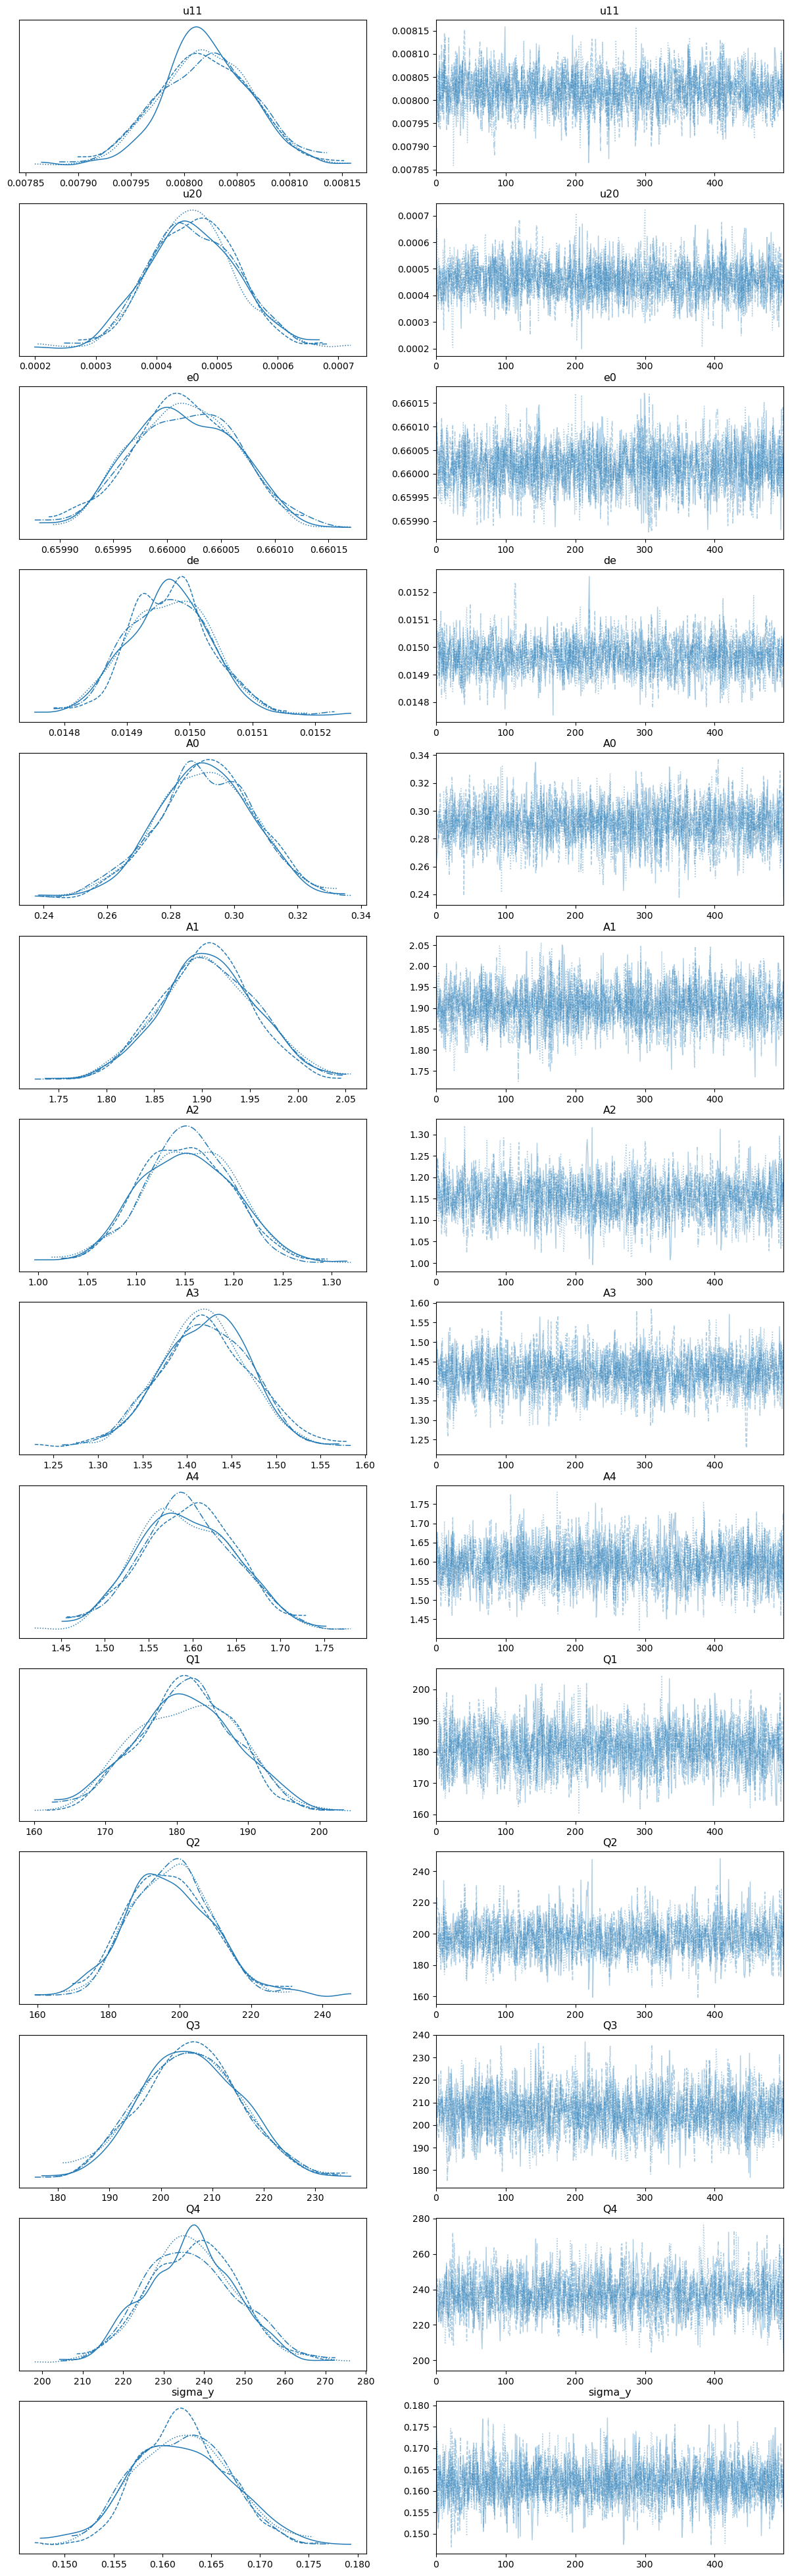

In [6]:
with simu_ham_model:
    simu_idata = pm.sample(500)

az.plot_trace(simu_idata, figsize=(15,50));

We visualize our fitting results by showing 25 fitting curves with inferred parameters. For each fitting curve, its parameter $\theta_i$ is uniformly drawn between 16 and 84 percentiles of their respective marginalized posterior distribution. 

mean         sd      hdi_3%     hdi_97%     mcse_mean  \
u11        0.008021   0.000044    0.007934    0.008095  8.800000e-07   
u20        0.000461   0.000072    0.000330    0.000596  1.340000e-06   
e0         0.660016   0.000050    0.659925    0.660106  9.400000e-07   
de         0.014967   0.000065    0.014841    0.015084  1.400000e-06   
A0         0.290972   0.015192    0.262528    0.319429  3.268300e-04   
A1         1.905663   0.050724    1.811195    2.001293  9.598400e-04   
A2         1.152366   0.047746    1.058640    1.234637  1.042020e-03   
A3         1.420188   0.049848    1.328890    1.511071  9.914700e-04   
A4         1.594201   0.054633    1.496687    1.697739  1.071630e-03   
Q1       181.328475   7.143850  167.098482  193.534471  1.525397e-01   
Q2       197.451467  11.659281  176.950020  219.772423  2.577827e-01   
Q3       205.837000   9.842198  187.545183  224.471103  1.950773e-01   
Q4       237.094800  11.387294  215.660266  257.561150  2.484859e-01   
sigma_y    0.162058   0.004879    0.153754    0.171677  8.793000e-05   

              mcse_sd     ess_bulk     ess_tail     r_hat  
u11      6.300000e-07  2422.849903  1519.324308  1.002370  
u20      9.700000e-07  2948.890474  1695.175410  0.999349  
e0       6.700000e-07  2771.402042  1431.214505  1.002836  
de       9.900000e-07  2224.335617  1654.962330  1.000090  
A0       2.311300e-04  2155.997196  1579.429721  1.005024  
A1       6.801600e-04  2781.223380  1685.941128  1.002918  
A2       7.369200e-04  2092.225843  1516.925645  1.002793  
A3       7.011500e-04  2548.989698  1401.914786  1.002433  
A4       7.588500e-04  2600.437695  1188.865064  1.001521  
Q1       1.078762e-01  2202.671766  1420.021437  1.007388  
Q2       1.823059e-01  2033.002912  1658.142952  1.001377  
Q3       1.379563e-01  2530.090900  1491.815908  0.999658  
Q4       1.757304e-01  2086.814566  1482.029973  0.999933  
sigma_y  6.229000e-05  3082.370417  1807.443604  1.005502

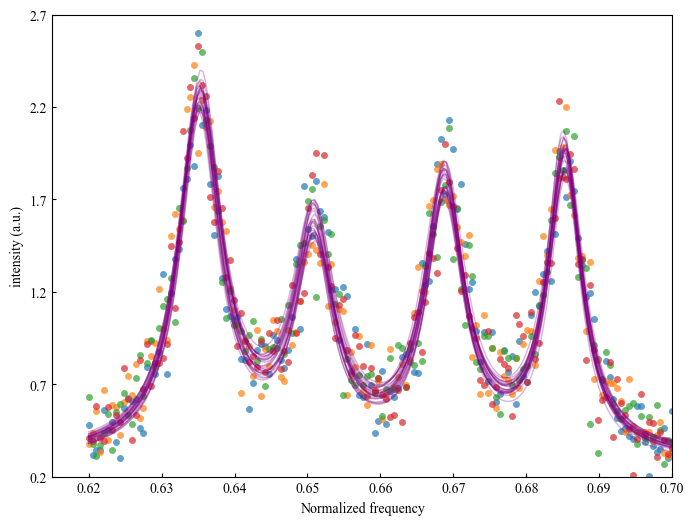

In [22]:
import random
summary = az.summary(simu_idata, round_to=8)
display(summary)

#plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y =zip(\
    summary['mean'].values-2*summary['sd'].values, summary['mean'].values+2*summary['sd'].values)


fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.set_xlabel("Normalized frequency")
ax.set_ylabel("intensity (a.u.)")
ax.set_xlim([0.615,0.70])
ax.set_ylim([0.2,2.7])
ax.set_yticks([0.2,0.7,1.2,1.7,2.2,2.7])
ax.tick_params(axis="both",direction='in',length=3)
ax.plot(simu_normf, simu_intensity.T, 'o',alpha  = 0.7, markersize = 5, markeredgecolor='none' )
for i in range(0,25):
    theta = [random.uniform(x[0],x[1]) for x in [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]]
    model_predictions = Model.prediction_model(theta, np.linspace(0.62,0.70,200))

    ax.plot(np.linspace(0.62,0.70,200), model_predictions, linewidth = 1,color = 'purple',alpha = 0.3)

We can see that all these fitting curves match with the simulated data. Thus, our package works reasonably well with the simulated data.

#### Inference on real data with proper priors

Similar to what we did with the simulated data, we need to look at the raw data, guess the typical values for peak parameters and then sample with generative model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 328 seconds.


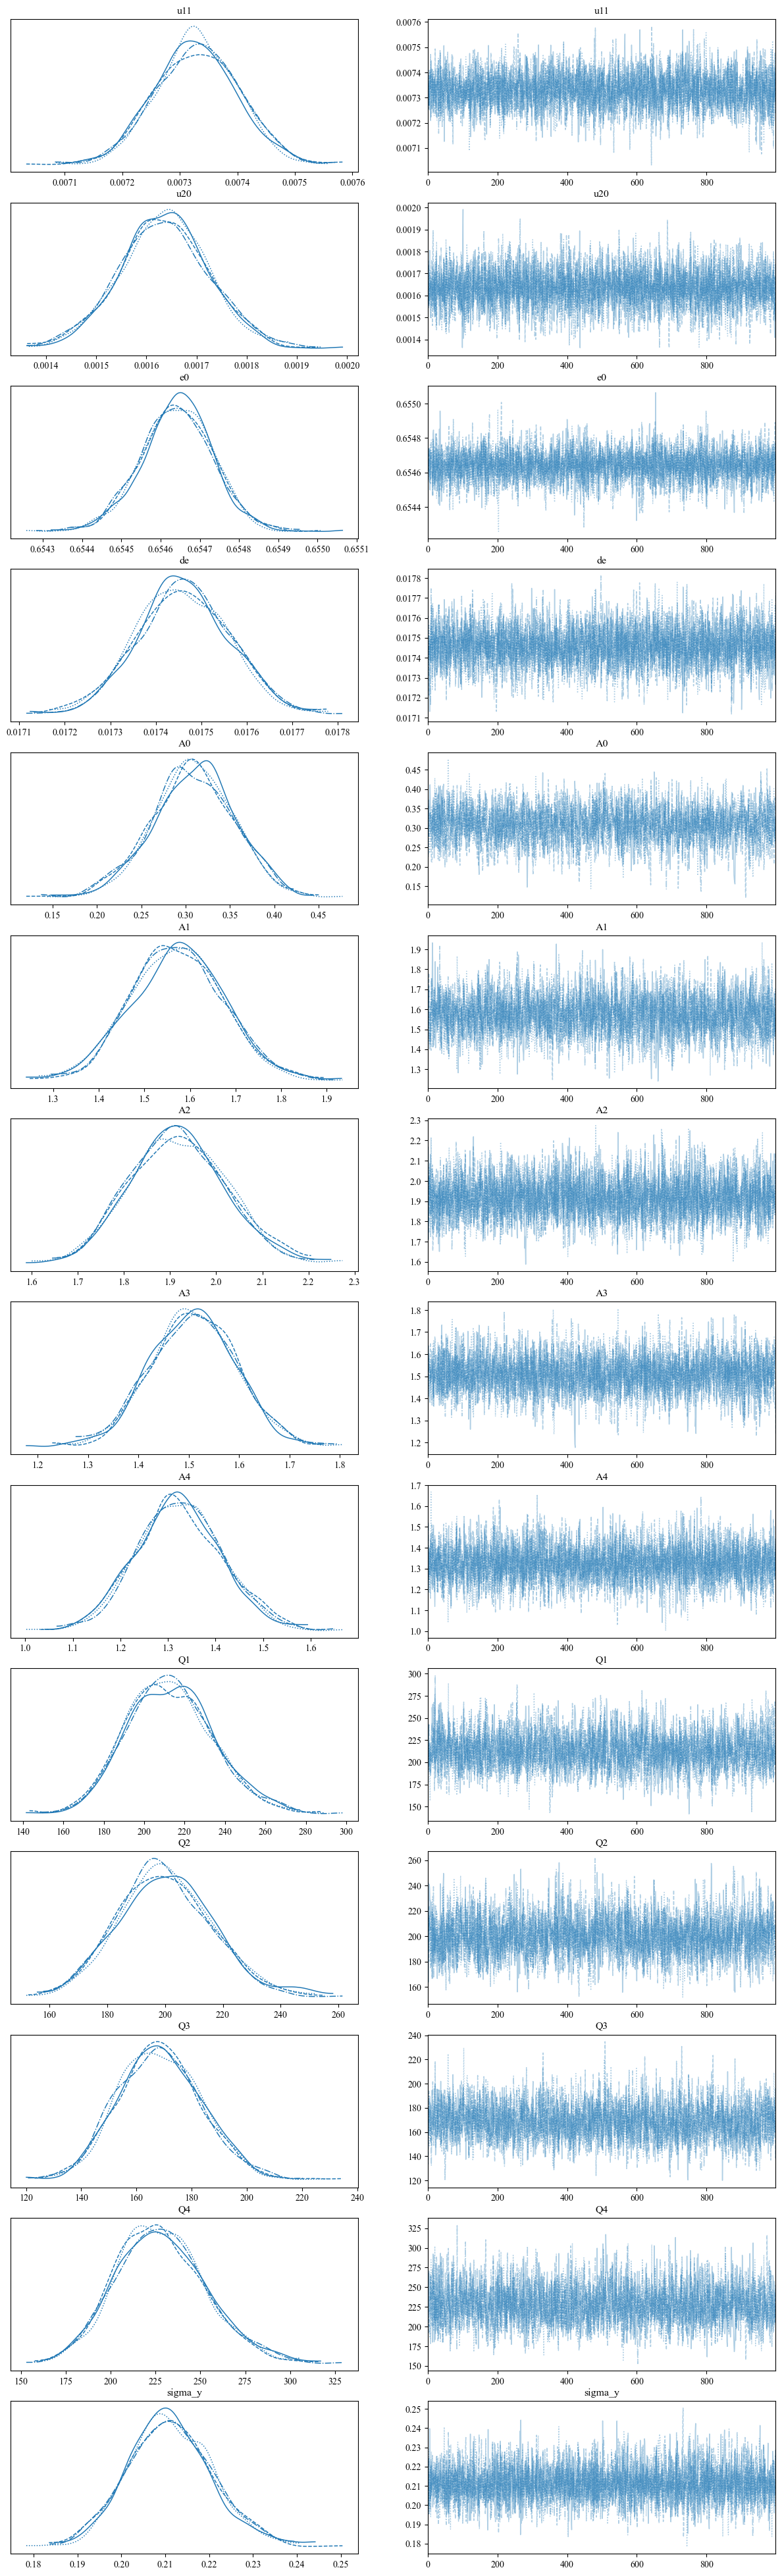

In [14]:
Q = [1/200]
A = [1/1.6]
priors_2 = {'u11':('Normal', [0.0074, 0.0002]),
               'u20':('Normal', [0.0017, 0.0001]),
               'e0':('Uniform', [0.64, 0.67]),
               'de':('Uniform', [0.005, 0.025]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', A),
               'A2':('Exponential', A),
               'A3':('Exponential', A),
               'A4':('Exponential', A),
               'Q1':('Exponential', Q), 
               'Q2':('Exponential', Q),
               'Q3':('Exponential', Q),
               'Q4':('Exponential', Q),
               'sigma_y':('Exponential', [1/0.2])}

#create the model 
ham_model = Model.Hamiltonian_model(real_data, priors_2)
with ham_model:
    idata = pm.sample(tune=500,draws=1000,chains=4,return_inferencedata=True,)

az.plot_trace(idata, figsize=(15,50));

mean         sd      hdi_3%     hdi_97%  mcse_mean  \
u11        0.007329   0.000072    0.007199    0.007469   0.000001   
u20        0.001635   0.000088    0.001465    0.001799   0.000001   
e0         0.654642   0.000091    0.654464    0.654804   0.000001   
de         0.017460   0.000102    0.017270    0.017648   0.000002   
A0         0.308082   0.046919    0.221664    0.397307   0.000986   
A1         1.572624   0.101666    1.387099    1.764124   0.001795   
A2         1.917895   0.103049    1.722638    2.107334   0.001603   
A3         1.509020   0.086037    1.345401    1.667842   0.001403   
A4         1.323927   0.089937    1.160378    1.497967   0.001351   
Q1       212.844145  21.211642  172.777424  251.666226   0.410576   
Q2       200.139950  16.334404  168.076869  228.879898   0.307200   
Q3       168.605984  15.161013  142.231332  198.122853   0.283627   
Q4       228.045157  24.995010  181.058110  275.488063   0.465148   
sigma_y    0.211193   0.009604    0.193388    0.229826   0.000122   

              mcse_sd     ess_bulk     ess_tail     r_hat  
u11      7.500000e-07  4636.248456  2918.895119  1.001918  
u20      8.400000e-07  5501.043114  3160.167369  1.000669  
e0       9.200000e-07  4899.411532  3067.513840  1.000230  
de       1.100000e-06  4208.161679  3100.651014  1.002120  
A0       6.974600e-04  2299.879443  2323.502182  1.000956  
A1       1.269100e-03  3203.668052  3098.448106  1.000243  
A2       1.137710e-03  4136.545889  2947.168786  1.000441  
A3       9.933000e-04  3789.449275  2851.073509  0.999684  
A4       9.565100e-04  4424.639230  3052.637280  1.000067  
Q1       2.903532e-01  2661.592924  2679.821711  1.000738  
Q2       2.183999e-01  2853.439777  2410.542669  1.000344  
Q3       2.005753e-01  2826.399805  2889.442716  1.000044  
Q4       3.289424e-01  2860.591416  2771.596782  1.000563  
sigma_y  8.646000e-05  6249.726164  2924.048368  1.001336

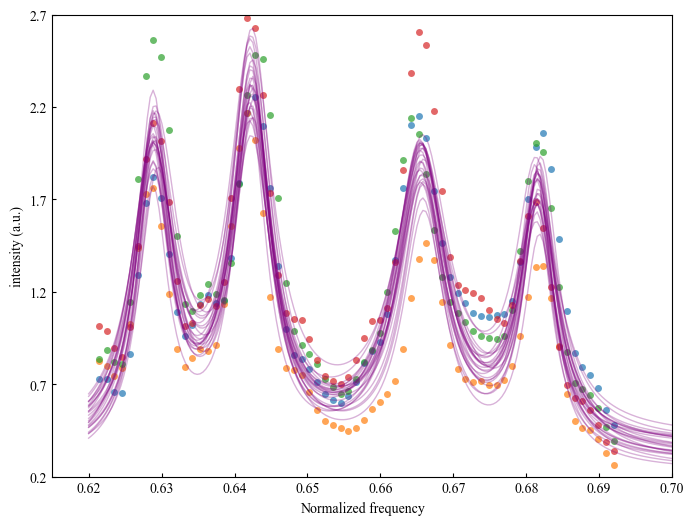

In [20]:
import random
summary = az.summary(idata, round_to=8)
display(summary)

#plot data with the fitting curves using values of the parameters uniformly drawn between 16 and 84 percentiles of
#their marginalized distribution.
u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y =zip(\
    summary['mean'].values-2*summary['sd'].values, summary['mean'].values+2*summary['sd'].values)


fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.set_xlabel("Normalized frequency")
ax.set_ylabel("intensity (a.u.)")
ax.set_xlim([0.615,0.70])
ax.set_ylim([0.2,2.7])
ax.set_yticks([0.2,0.7,1.2,1.7,2.2,2.7])
ax.tick_params(axis="both",direction='in',length=3)
ax.plot(freq, intensity.T, 'o',alpha  = 0.7, markersize = 5, markeredgecolor='none' )
for i in range(0,25):
    theta = [random.uniform(x[0],x[1]) for x in [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]]
    model_predictions = Model.prediction_model(theta, np.linspace(0.62,0.70,200))

    ax.plot(np.linspace(0.62,0.70,200), model_predictions, linewidth = 1,color = 'purple',alpha = 0.3)

#### Pair plots
We get pretty reasonable results from the model. With sampled data, we can do a lot of analysis. The following cells show some pair plots to visualize the posterior for different parameter groups.

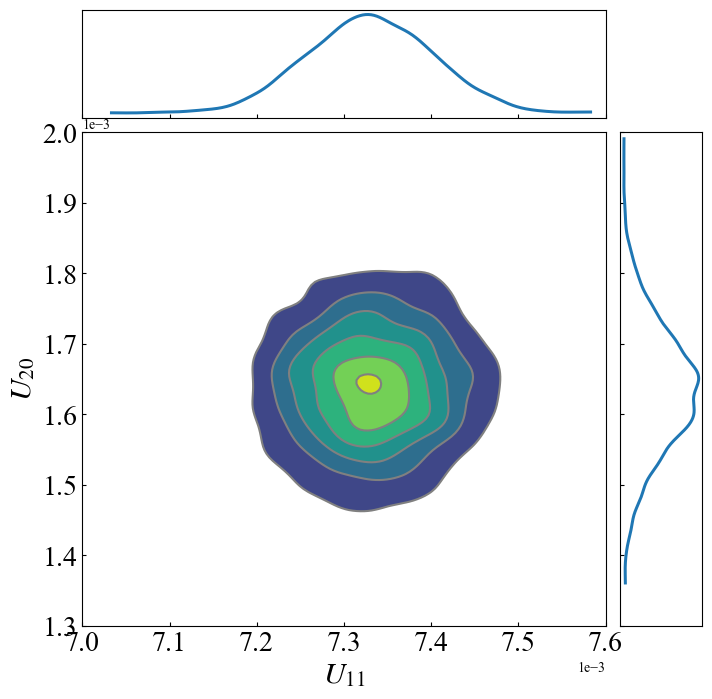

In [16]:
# plot the marginalized posteriors of u11 and u20
import arviz.labels as azl
labeller = azl.MapLabeller(var_name_map={"u11": r"$U_{11}$","u20": r"$U_{20}$"})
from matplotlib import rcParams
font = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size' : 13,
         }
confont = {
           'font.family' : 'serif',
           'mathtext.fontset':'stix',
           'font.serif':'Times New Roman',
           'font.size' : 10,
         }
rcParams.update(confont)
ff = az.plot_pair(idata,var_names=["u11", "u20"], labeller =labeller, marginals=True,figsize=(8, 8),kind='kde')
ff[1,0].set_xlim([0.007,0.0076])
ff[1,0].set_ylim([0.0013,0.0020])
ff[1,0].tick_params(axis="both",direction='in',length=3)
ff[0,0].tick_params(axis="both",direction='in',length=3)
ff[1,1].tick_params(axis="both",direction='in',length=3)
ff[1,0].ticklabel_format(style="sci", axis='both', scilimits=(0,0))

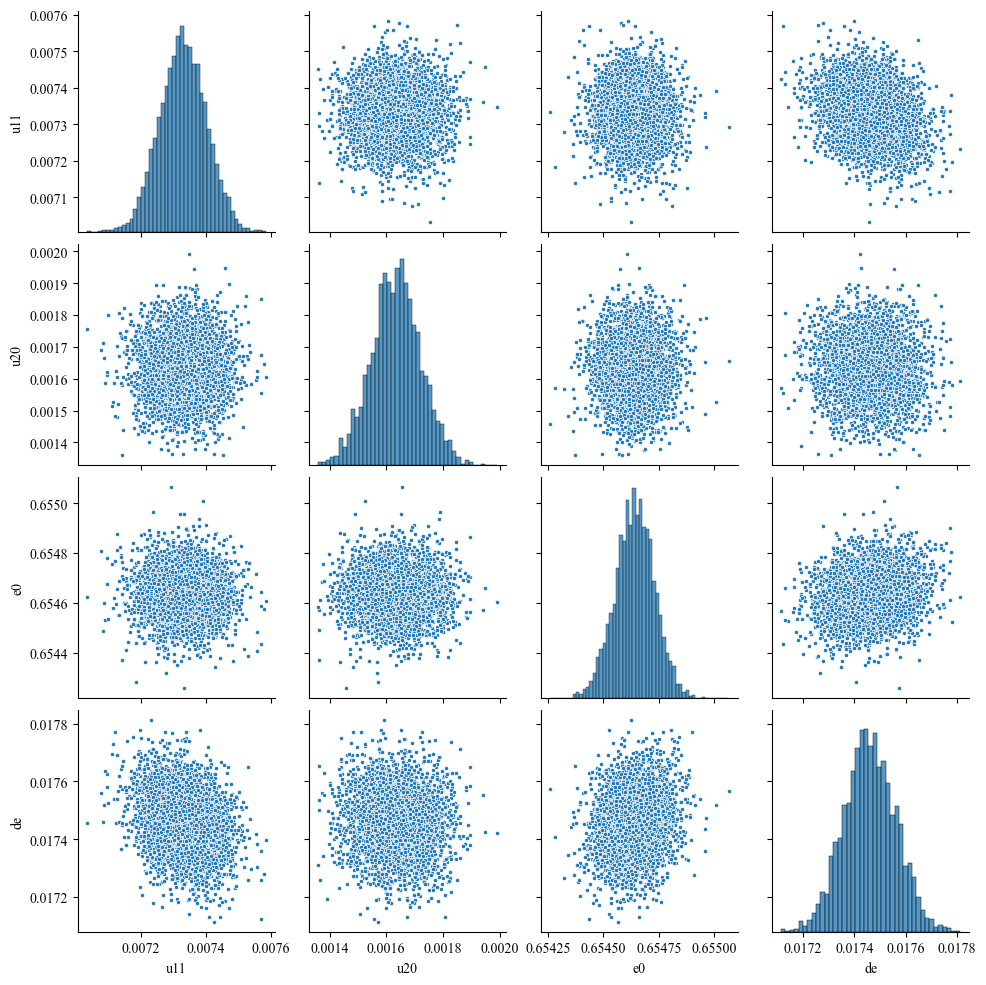

In [17]:
#pair plots between coupling strengths and uncoupled energies
P_couple =["u11", "u20", "e0", "de"]
best_fit_sel1 = idata.posterior.to_dataframe().loc[:, P_couple]
sns.pairplot(best_fit_sel1, markers='.');

The low correlation of these coupling strengths and energies shown in the above pair plot matches with our expectation since these parameters are physically independent.

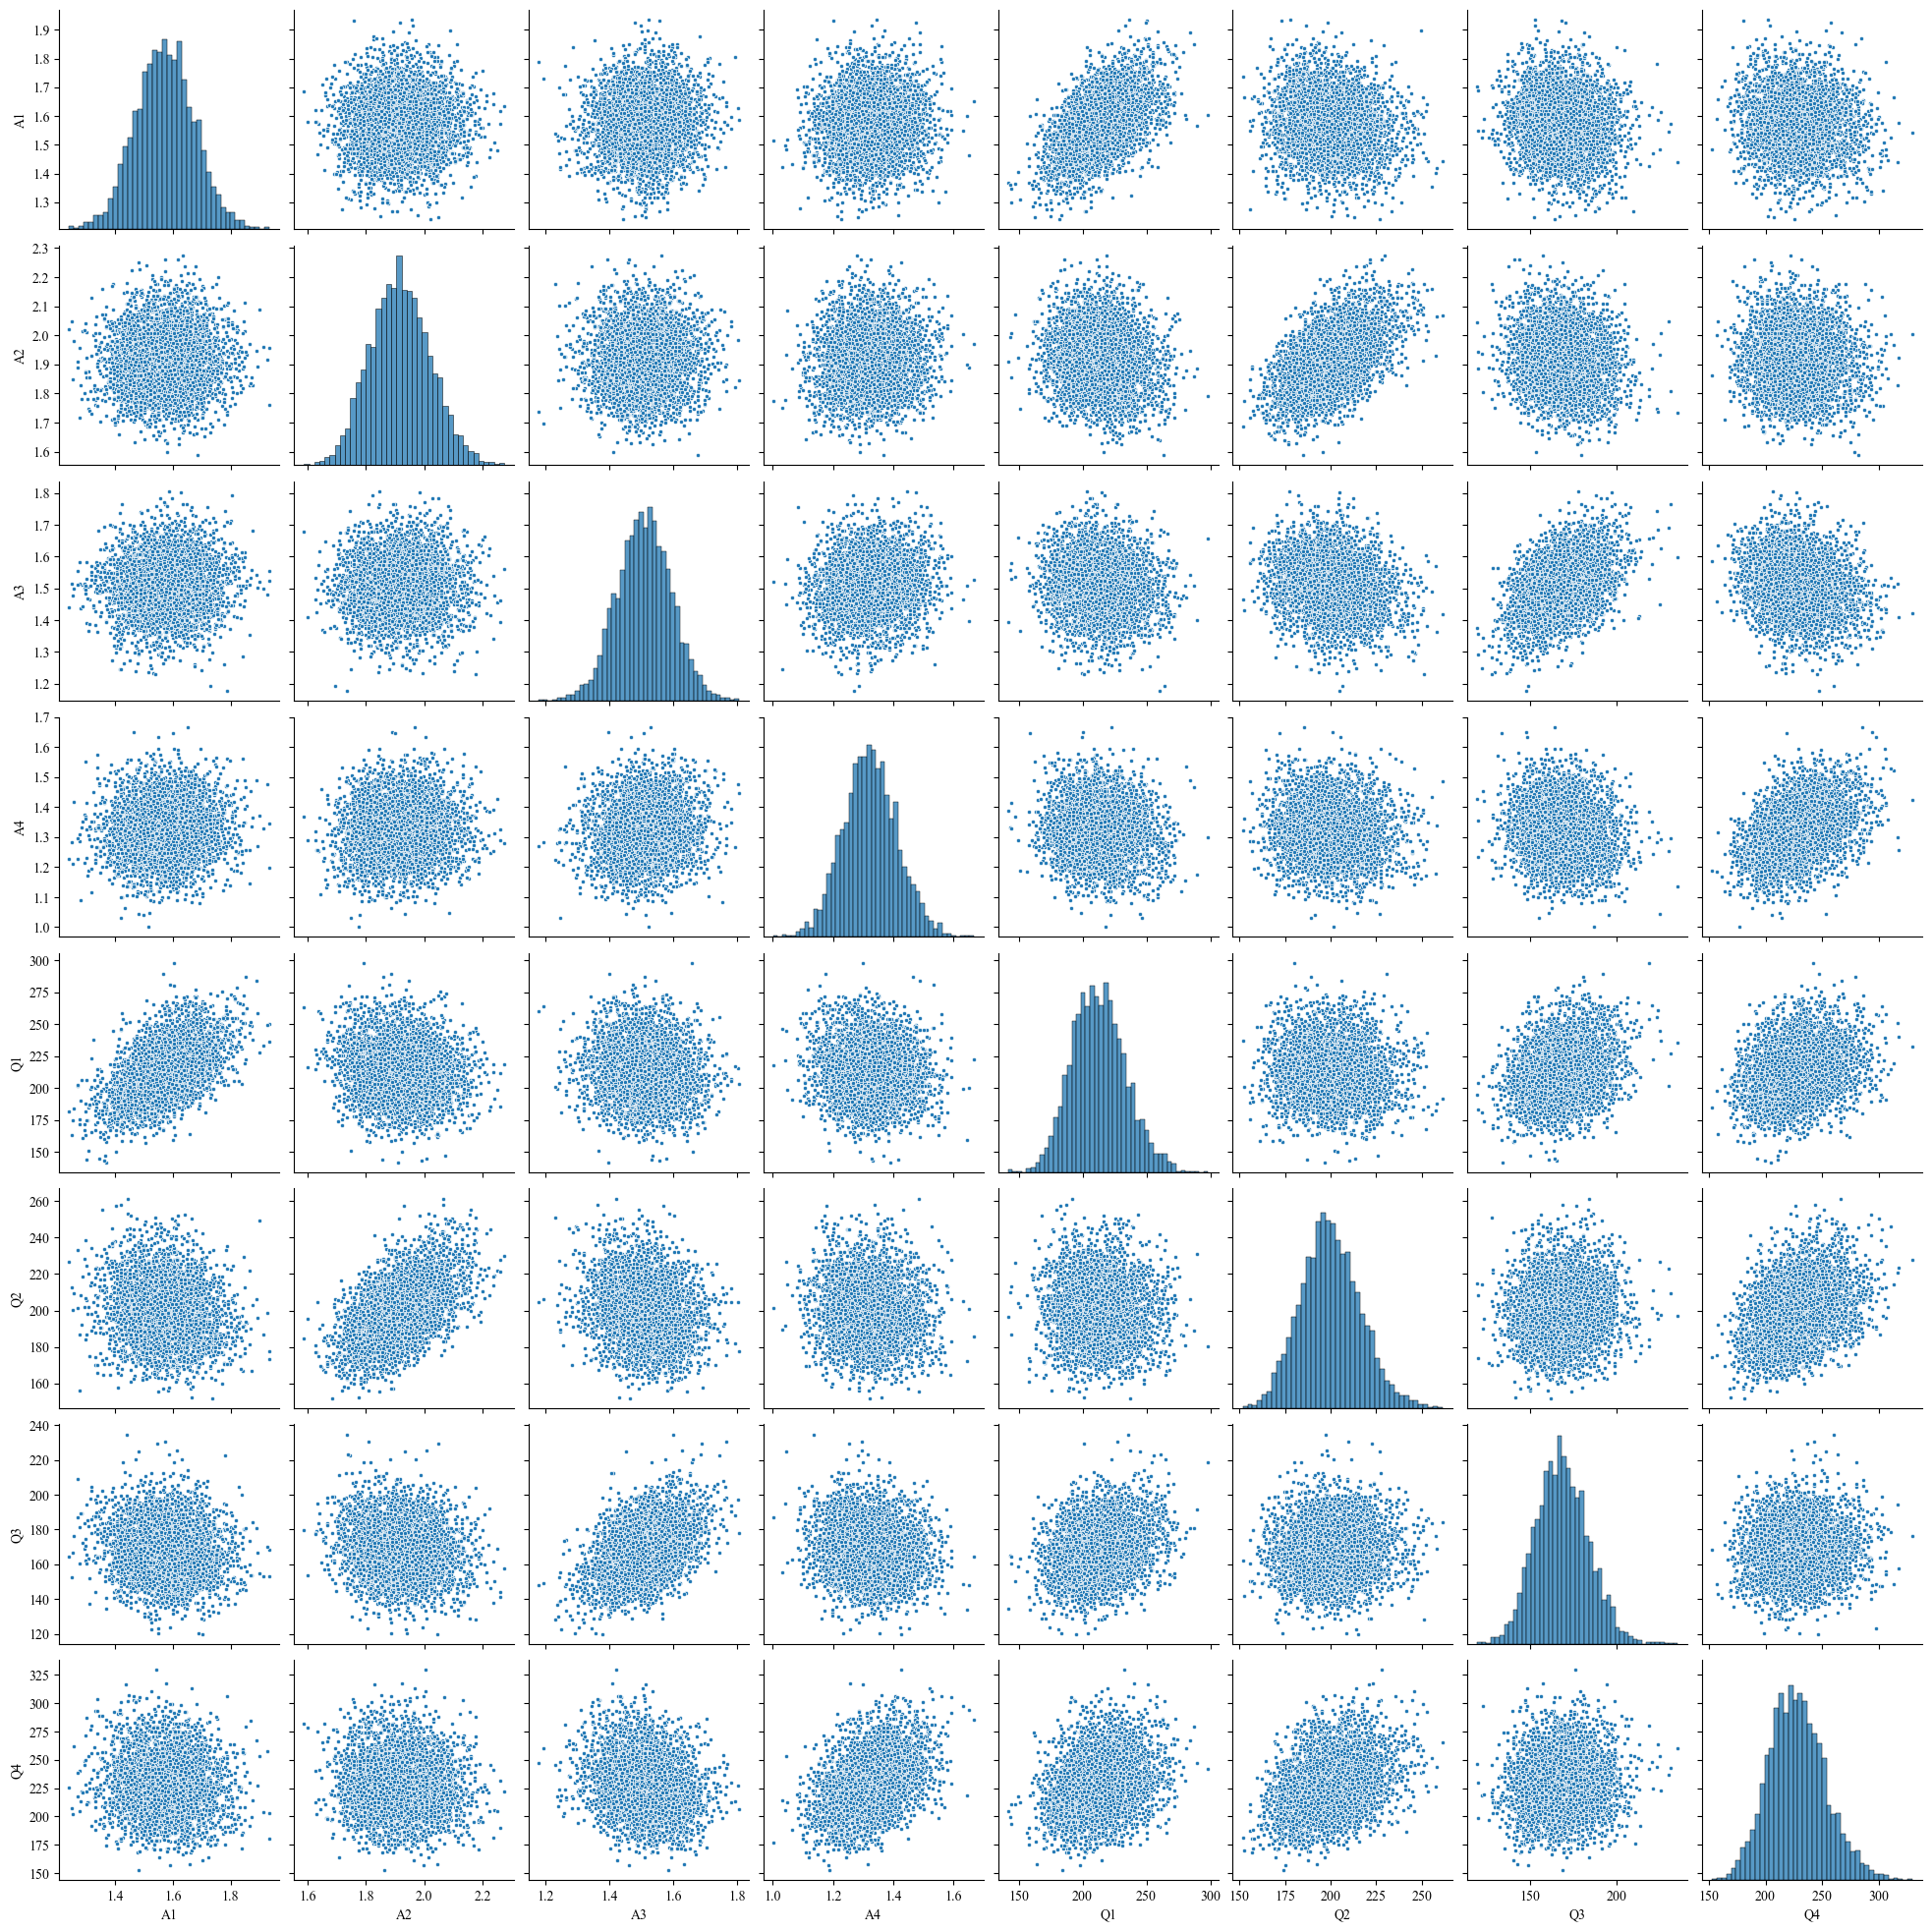

In [19]:
# peak height and peak width covarience
AandQ =["A1", "A2", "A3", "A4", "Q1", "Q2", "Q3", "Q4"]
best_fit_sel2 = idata.posterior.to_dataframe().loc[:, AandQ]
sns.pairplot(best_fit_sel2, markers='.');

#### Calculation on more k points of two different PhC chips

We have evaluated the performance of our model on different k-point spectra and obtained well-fitted spectra with reasonable coupling terms. The figure below displays the mean and standard deviation of $U_{11}$ and $U_{20}$ that we inferred from two different PhC chips, 7 different $k$ points for PhC chip 1 (figure a and c) and 5 different $k$ point for PhC chip 2 (figure b and d). All the data we used to inferred are available in the data folder of our package. We expected that the values of these coupling terms are universal across different k-points in momentum space of each chip. Indeed, our inferred results clearly shows this universality. Thus, this is a strong evidence for the validity and robustness of our model and parameter estimation.

<img src="reference_img\u11u20.png" alt="Image" width="1000px" height="750px"/>